In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping

In [13]:
malaria_data = tfds.load('malaria',split='train',shuffle_files=True,as_supervised=True)

In [15]:
IMG_SIZE = 103
num_samples = tf.data.experimental.cardinality(malaria_data).numpy()
train_size = int(0.8 * num_samples)

train = malaria_data.take(train_size)
test = malaria_data.skip(train_size)

# def preprocess(image,label):
#     image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
#     label = tf.cast(image,tf.float32)/255.0
#     return image,label


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label


train = train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test = test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
model = Sequential()

In [17]:
model.add(Conv2D(filters=16,kernel_size=2,padding='same',activation='relu',input_shape=(103,103,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu',input_shape=(103,103,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu',input_shape=(103,103,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.add(Flatten())
model.add(Dense(500,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(layers.Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [24]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(
    train,validation_data=test,epochs=10,callbacks=[early_stop]
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 183ms/step - accuracy: 0.9457 - loss: 0.3827 - val_accuracy: 0.9552 - val_loss: 0.1930
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 121s 160ms/step - accuracy: 0.9560 - loss: 0.1891 - val_accuracy: 0.9554 - val_loss: 0.1782
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.9565 - loss: 0.1775 - val_accuracy: 0.9496 - val_loss: 0.1823
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 143s 157ms/step - accuracy: 0.9567 - loss: 0.1690 - val_accuracy: 0.9516 - val_loss: 0.1819
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 154s 175ms/step - accuracy: 0.9567 - loss: 0.1646 - val_accuracy: 0.9505 - val_loss: 0.1774
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.9551 - loss: 0.1678 - val_accuracy: 0.9521 - val_loss: 0.1730
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.9551 - loss: 0.1650 - val_accuracy: 0.9528 - val_loss: 0.1823
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 157ms/step - accuracy: 0.9575 -

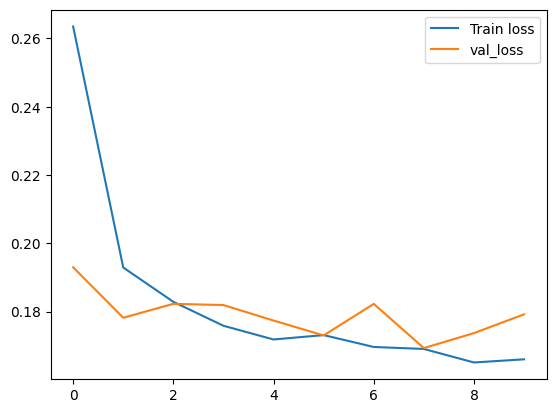

In [26]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

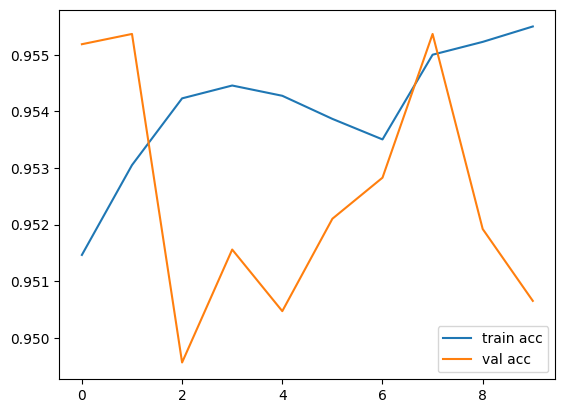

In [27]:
plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()